<a href="https://colab.research.google.com/github/ethanmjansen/Central_Park_Squirrels/blob/master/notebooks/Unit_2_Build.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#My Data Prework

In [0]:
#Initial Imports
import pandas as pd
from google.colab import files
import numpy as np
import matplotlib.pyplot as plt
!pip install category_encoders==2.*
!pip install eli5
!pip install eli5
!pip install pdpbox
!pip install shap

In [0]:
uploaded = files.upload()

Saving 2018_Central_Park_Squirrel_Census_-_Squirrel_Data.csv to 2018_Central_Park_Squirrel_Census_-_Squirrel_Data (1).csv


In [0]:
df = pd.read_csv('2018_Central_Park_Squirrel_Census_-_Squirrel_Data.csv')

In [0]:
#Replace all whitespace with underscore
df.columns = df.columns.str.replace(' ', '_')

In [0]:
df.columns = df.columns.str.replace('X', 'Longitude')

In [0]:
df.columns = df.columns.str.replace('Y', 'Latitude')

In [0]:
df.columns

Index(['Longitude', 'Latitude', 'Unique_Squirrel_ID', 'Hectare', 'Shift',
       'Date', 'Hectare_Squirrel_Number', 'Age', 'Primary_Fur_Color',
       'Highlight_Fur_Color', 'Combination_of_Primary_and_Highlight_Color',
       'Color_notes', 'Location', 'Above_Ground_Sighter_Measurement',
       'Specific_Location', 'Running', 'Chasing', 'Climbing', 'Eating',
       'Foraging', 'Other_Activities', 'Kuks', 'Quaas', 'Moans', 'Tail_flags',
       'Tail_twitches', 'Approaches', 'Indifferent', 'Runs_from',
       'Other_Interactions', 'Lat/Long', 'Zip_Codes', 'Community_Districts',
       'Borough_Boundaries', 'City_Council_Districts', 'Police_Precincts'],
      dtype='object')

#Define Target

In [0]:
#Brief Clean to Define Target
indexNames = df[ (df['Runs_from'] == True) & (df['Indifferent'] == True) ].index
df.drop(indexNames , inplace=True)

In [0]:
#This is my target
df['Target'] = df['Approaches'] | df['Indifferent'] == True
df['Target'].value_counts()

True     1581
False    1410
Name: Target, dtype: int64

#What Accuracy can I get just by guessing?

In [0]:
print(df['Target'].value_counts(max))
print(f'If I only guessed Majority Class I would be \nright only 52.9% of the time')

True     0.528586
False    0.471414
Name: Target, dtype: float64
If I only guessed Majority Class I would be 
right only 52.9% of the time


#Train Test Split

In [0]:
#Train Test Split Classifier
from sklearn.model_selection import train_test_split
#The actual Split
train, test = train_test_split(df, 
                               train_size=0.80,
                               test_size=0.20,
                               random_state=42)

#Train/Val/Test Split
train, val = train_test_split(train, 
                               train_size=0.80,
                               test_size=0.20,
                               random_state=42)

train.shape,val.shape, test.shape

((1913, 37), (479, 37), (599, 37))

# Models

##Linear Model 

In [0]:
#Model Imports
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler

In [0]:
#Make X features Matrix and y vector 
columns1 = ['Shift', 'Foraging', 'Longitude', 'Latitude', 'Primary_Fur_Color', 'Eating', 'Highlight_Fur_Color']
target = 'Target'
X_train = train[columns1]
y_train = train[target]
X_val = val[columns1]
y_val = val[target]
X_test = test

In [0]:
#One-Hot Encoding everything
encoder = ce.OneHotEncoder(use_cat_names=True)
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)

In [0]:
#Imputing missing values
imputer = SimpleImputer()
X_train_imputed = imputer.fit_transform(X_train_encoded)
X_val_imputed = imputer.transform(X_val_encoded)

In [0]:
#Scaling everything
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_val_scaled = scaler.transform(X_val_imputed)

In [0]:
#Fitting Model and getting score
model = LogisticRegressionCV(cv=5, n_jobs=-1, random_state=42)
model.fit(X_train_scaled, y_train)
print('Validation Accuracy', model.score(X_val_scaled, y_val))

Validation Accuracy 0.6221294363256785


##Classification Model 

In [0]:
#Model Imports
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier

In [0]:
#Make X features Matrix and y vector 
columns_to_drop = ['Unique_Squirrel_ID', 'Approaches', 'Indifferent', 'Runs_from', 'Target']
target = 'Target'
X_train = train.drop(columns=columns_to_drop)
y_train = train[target]
X_val = val.drop(columns=columns_to_drop)
y_val = val[target]
X_test = test

In [0]:
#Make Pipeline
pipeline = make_pipeline(ce.OrdinalEncoder(), 
                         SimpleImputer(strategy='mean'), 
                         RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=27))

In [0]:
# Fit on train, score on val
pipeline.fit(X_train, y_train)
print('Validation Accuracy', pipeline.score(X_val, y_val))

Validation Accuracy 0.6722338204592901


##Feature Permutations

In [0]:
#Imports
import eli5
from eli5.sklearn import PermutationImportance

In [0]:
#Making transformers
transformers = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='mean')
)

In [0]:
#Fitting transformers to X_train and X_val
X_train_transformed = transformers.fit_transform(X_train)
X_val_transformed = transformers.transform(X_val)

model = RandomForestClassifier(n_estimators=300, random_state=27, n_jobs=-1)
model.fit(X_train_transformed, y_train)

In [0]:
#Calculate Permutatin Importances
permuter = PermutationImportance(
    model, 
    scoring='accuracy', 
    n_iter=5, 
    random_state=27
)

permuter.fit(X_val_transformed, y_val)

In [0]:
#Nice Display of Feature Permutations
feature_names = X_val.columns.tolist()
eli5.show_weights(
    permuter, 
    top=None,
    feature_names=feature_names
)

Weight,Feature
0.0380 ± 0.0202,Shift
0.0359 ± 0.0116,Foraging
0.0334 ± 0.0203,Longitude
0.0330 ± 0.0442,Date
0.0267 ± 0.0148,Hectare
0.0238 ± 0.0192,Latitude
0.0196 ± 0.0202,Hectare_Squirrel_Number
0.0125 ± 0.0095,Age
0.0092 ± 0.0043,Other_Interactions
0.0079 ± 0.0110,Primary_Fur_Color


#The Model I will use for the test

In [0]:
#Make X features Matrix and y vector 
columns = ['Shift', 'Foraging', 'Longitude', 'Latitude', 'Primary_Fur_Color', 'Eating', 'Highlight_Fur_Color']
target = 'Target'
X_train = train[columns]
y_train = train[target]
X_val = val[columns]
y_val = val[target]
X_test = test[columns]
y_test = test[target]

In [0]:
#Make Pipeline
new_pipeline = make_pipeline(ce.OrdinalEncoder(), 
                         SimpleImputer(strategy='mean'), 
                         RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=27))

In [0]:
# Fit on train, score on val
new_pipeline.fit(X_train, y_train)
print('Validation Accuracy', new_pipeline.score(X_val, y_val))

Validation Accuracy 0.6743215031315241


In [0]:
# Fit on train, score on test
new_pipeline.fit(X_train, y_train)
print('Validation Accuracy', new_pipeline.score(X_test, y_test))

Validation Accuracy 0.6043405676126878


#Feature paramaters

In [0]:
df['X'].describe()

count    2991.000000
mean      -73.967238
std         0.007712
min       -73.981159
25%       -73.973190
50%       -73.968655
75%       -73.960302
max       -73.949722
Name: X, dtype: float64

In [0]:
df['Y'].describe()

count    2991.000000
mean       40.780775
std         0.010257
min        40.764911
25%        40.771617
50%        40.778066
75%        40.791166
max        40.800119
Name: Y, dtype: float64

In [0]:
df['Primary_Fur_Color'].value_counts()

Gray        2446
Cinnamon     389
Black        101
Name: Primary Fur Color, dtype: int64

In [0]:
df['Highlight_Fur_Color'].value_counts()

Cinnamon                  758
White                     579
Cinnamon, White           262
Gray                      170
Gray, White                58
Black                      34
Black, Cinnamon, White     31
Black, White               10
Black, Cinnamon             9
Gray, Black                 3
Name: Highlight_Fur_Color, dtype: int64

In [0]:
df['Age'].value_counts()

Adult       2542
Juvenile     324
?              4
Name: Age, dtype: int64

#Practice Prediction


In [0]:
def predict(Shift, Foraging, X, Y, Primary_Fur_Color, Eating, Highlight_Fur_Color):
    df = pd.DataFrame(
        columns=['Shift', 'Foraging', 'X', 'Y', 'Primary_Fur_Color', 'Eating', 'Highlight_Fur_Color'], 
        data=[[Shift, Foraging, X, Y, Primary_Fur_Color, Eating, Highlight_Fur_Color]]
    )
    y_pred = new_pipeline.predict(df)[0]
    return f'{y_pred}'

In [0]:
predict('AM', True, 40.78, -73.96, 'Gray', True, 'Black')

'True'

# Visuals 

## Partial Dependence Plots

In [0]:
#Imports
import matplotlib.pyplot as plt
from pdpbox.pdp import pdp_isolate, pdp_plot
#So the Graphs aren't fuzzy 
plt.rcParams['figure.dpi'] = 72

In [0]:
#First Isolated Feature 

feature = 'Longitude'

isolated = pdp_isolate(
    model=new_pipeline, 
    dataset=X_val, 
    model_features=X_val.columns, 
    feature=feature
)

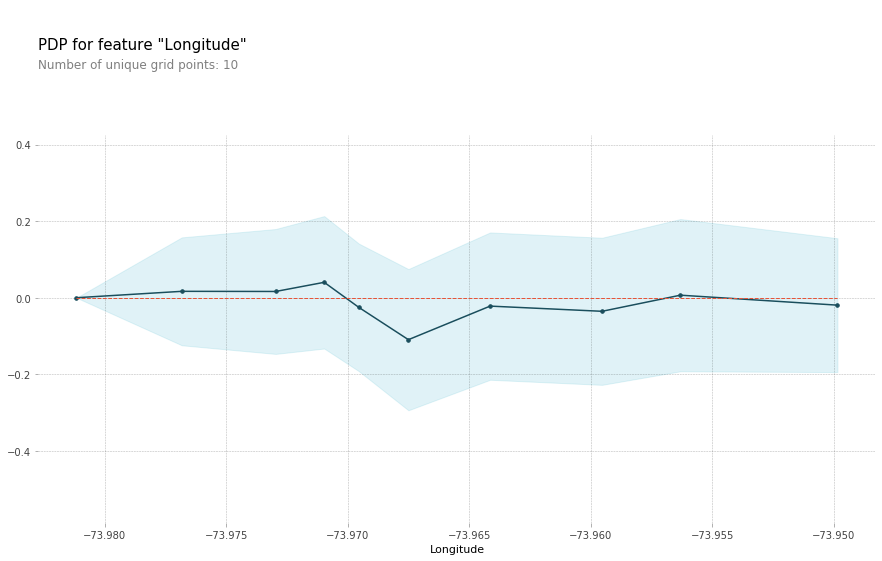

In [0]:
#PDP plot for Longitude
ax1 = pdp_plot(isolated, feature_name=feature);

In [0]:
#Second Isolated Feature
feature = 'Latitude'

isolated = pdp_isolate(
    model=new_pipeline, 
    dataset=X_val, 
    model_features=X_val.columns, 
    feature=feature
)

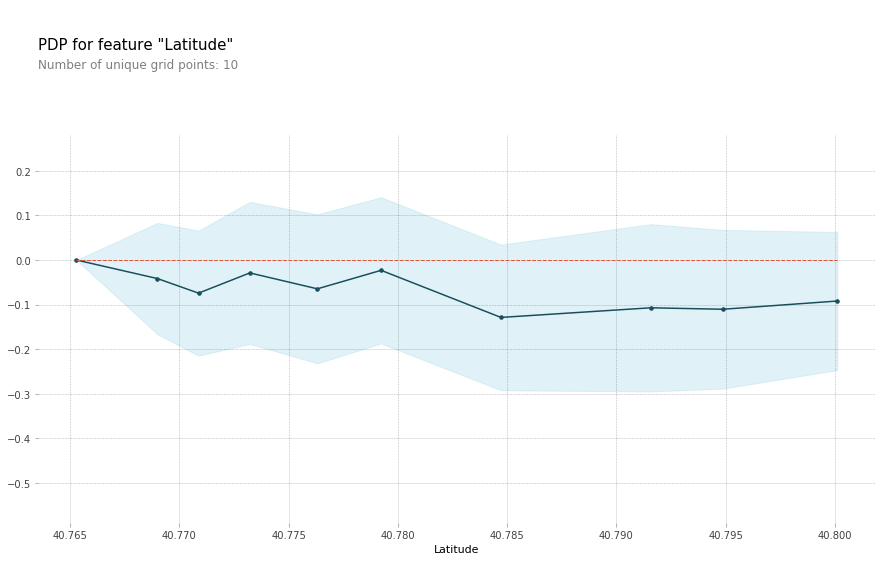

In [0]:
#PDP plot for Latitude
pdp_plot(isolated, feature_name=feature);

#Double Partial Dependence Plot

In [0]:
#Imports 
from pdpbox.pdp import pdp_interact, pdp_interact_plot

In [0]:
#Latitude and Longitude Comparison
features = ['Longitude', 'Latitude']

interaction = pdp_interact(
    model=new_pipeline,
    dataset=X_val, 
    model_features=X_val.columns, 
    features=features
)

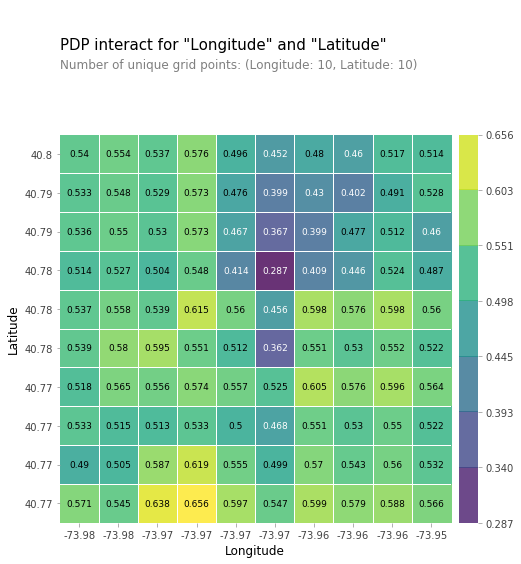

In [0]:
#The Actual Plot
pdp_interact_plot(interaction, plot_type='grid', 
                  feature_names=features);

##Confusion Matrix

In [0]:
y_pred = new_pipeline.predict(X_test)

In [0]:
#SKLearn's function
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import seaborn as sns
confusion_matrix(y_test, y_pred)

array([[154, 113],
       [124, 208]])

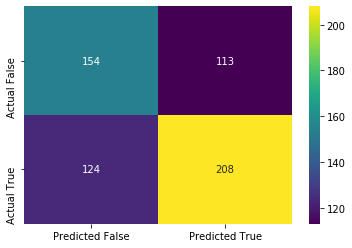

In [0]:
#Reader friendly
def plot_confusion_matrix(y_true, y_pred):
    labels = unique_labels(y_true)
    columns = [f'Predicted {label}' for label in labels]
    index = [f'Actual {label}' for label in labels]
    table = pd.DataFrame(confusion_matrix(y_true, y_pred), 
                         columns=columns, index=index)
    return sns.heatmap(table, annot=True, fmt='d', cmap='viridis')

plot_confusion_matrix(y_test, y_pred);

#Pickle the Pipeline

In [0]:
#The Pickle 
from joblib import dump
dump(new_pipeline, 'pipeline.joblib', compress=True)

['pipeline.joblib']

In [0]:
#Download the file
files.download('pipeline.joblib')

In [0]:
#What version did I use?
import joblib
import sklearn
import category_encoders as ce
print(f'joblib=={joblib.__version__}')
print(f'scikit-learn=={sklearn.__version__}')
print(f'category_encoders=={ce.__version__}')

joblib==0.14.1
scikit-learn==0.22.1
category_encoders==2.1.0
